In [1]:
%matplotlib inline
import skyflux as sf

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [44]:
# Set up a healpy interpolator

nside = 64

theta, phi = hp.pix2ang(nside, np.arange(12 * nside * nside))

#! I think we will have to revisit these values to expand the healpy
    # interpolator, once we have tested it out at least once.
list_az = phi
list_alt = np.pi / 2 - theta
#J = sf.stokes.spline_beam_func(151e6, alt, az)

J_full = sf.stokes.create_J(az=list_az, alt=list_alt, nu=151e6, radians=True)

In [45]:
J_full.shape
A_full = np.array([
  sf.stokes.create_A(J=Ji) for Ji in J_full
])


In [46]:
print(J_full.shape)
print(A_full.shape)


(49152, 2, 2)
(49152, 4, 4)


In [47]:
#lst_now_deg = np.degrees(sf.rot.get_lst(radians=False))
#az, alt = sf.rot.eq_to_topo(lst_now_deg, sf.rot.hera_lat, 
#                            sf.rot.hera_lat, lst_now_deg, radians=False)

In [48]:
S = .5 * np.array([[1, 1, 0, 0,],
                  [0, 0, 1, 1j],
                  [0, 0, 1, -1j],
                  [1, -1, 0, 0]])

def val_interp(A_section, az, alt):
    """
    Abbreviation and conversion function. We get the interpolation value
    assuming @az and @alt are in degrees.
    """
    colatitude = np.radians(90 - alt)
    longitude = np.radians(az)
    return hp.get_interp_val(A_section, colatitude, longitude)

J_shell = np.zeros((2, 2), dtype=np.complex128)

def J_interp(J_full):
    def interpolator(az, alt):
        colatitude = np.pi / 2 - alt
        longitude = az
        J = np.copy(J_shell)
        for i in range(0, 2):
            for j in range(0, 2):
                J[i, j] = hp.get_interp_val(J_full[:, i, j], colatitude, longitude)
        J_outer = np.kron(J, np.conj(J))
        return np.dot(np.linalg.inv(S), np.dot(J_outer, S))
    return interpolator

A_shell = np.zeros((4, 4), dtype=np.complex128)

def A_interp(A_full):
    def interpolator(az, alt):
        colatitude = np.pi / 2 - alt
        longitude = az
        A = np.copy(A_shell)
        for i in range(0, 4):
            for j in range(0, 4):
                A[i, j] = hp.get_interp_val(A_full[:, i, j], colatitude, longitude)
        return A
    return interpolator

def minimal_A_interp(A_full):
    def interpolator(az, alt):
        colatitude = np.pi / 2 - alt
        longitude = az
        A = np.copy(A_shell)
        for i in range(0, 4):
            A[i, 0] = hp.get_interp_val(A_full[:, i, 0], colatitude, longitude)
        return A
    return interpolator

In [49]:
interpolator = A_interp(A_full)

In [50]:
# list_sources = None -> defaults to full sky

list_lst, list_vis = sf.vis.new_sources_over_time(
    88, 121, sf.catalog.obj_catalog[:100],
    start=0, end=2/3 * np.pi, interval=np.pi / 72, nu=151e6,
    interpolator = A_interp(A_full)
)
#vist

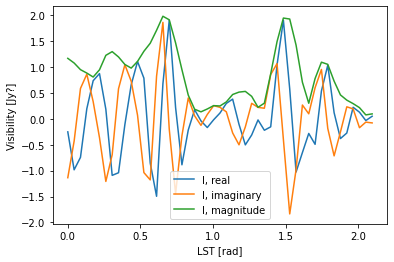

In [51]:
# Theoretically, the rest of the notebook should proceed exactly as LST_new_approach,
# because we just wanted the total visibility at a certain time
# So, it is like having one source that is much brighter and also a sum of Gaussians,
    # rather than a single Gaussian
I = np.array([v[0] for v in list_vis])

plt.plot(list_lst, np.real(I), label="I, real")
plt.plot(list_lst, np.imag(I), label="I, imaginary")
plt.plot(list_lst, np.abs(I), label="I, magnitude")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")

plt.legend()
plt.show()

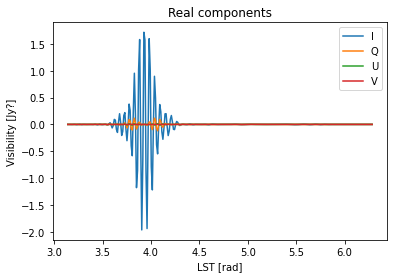

In [15]:
Q = np.array([v[1] for v in list_vis])
U = np.array([v[2] for v in list_vis])
V = np.array([v[3] for v in list_vis])

plt.plot(list_lst, np.real(I), label="I")
plt.plot(list_lst, np.real(Q), label="Q")
plt.plot(list_lst, np.real(U), label="U")
plt.plot(list_lst, np.real(V), label="V")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")
plt.title("Real components")

plt.legend()
plt.show()

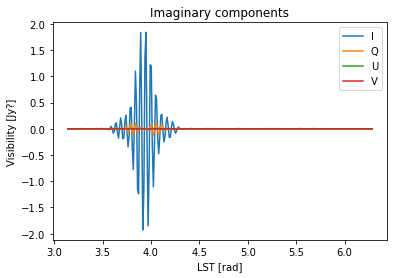

In [16]:
plt.plot(list_lst, np.imag(I), label="I")
plt.plot(list_lst, np.imag(Q), label="Q")
plt.plot(list_lst, np.imag(U), label="U")
plt.plot(list_lst, np.imag(V), label="V")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")
plt.title("Imaginary components")

plt.legend()
plt.show()

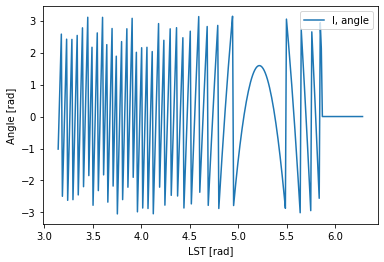

In [17]:
# it is like a phase wrapping effect, that is why there is a sort of symmetry about the soft lump

plt.plot(list_lst, np.angle(I), label="I, angle")

plt.xlabel("LST [rad]")
plt.ylabel("Angle [rad]")

plt.legend()
plt.show()

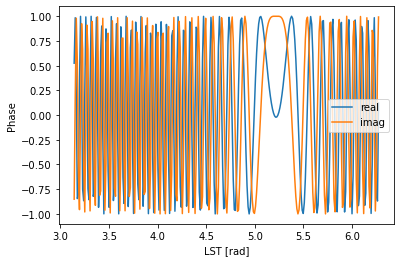

In [18]:
lst_list = [np.pi / 288 * i for i in range(288, 576)]

#print(lst_list)

phases = np.array([sf.ant.phase_factor(88, 121, sf.rot.radec2lm(ra, dec, ra0=lst)) for lst in 
    lst_list
])
plt.plot(lst_list, np.real(phases), label="real")
plt.plot(lst_list, np.imag(phases), label="imag")

plt.xlabel("LST [rad]")
plt.ylabel("Phase")

plt.legend()
plt.show()

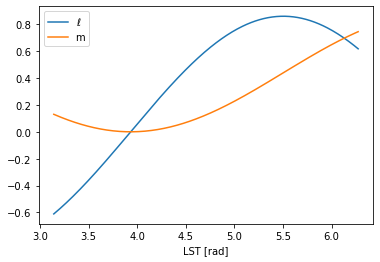

In [19]:
# The source does not pass through zenith
# m should reach zero for it to be considered zenith

lst_list = [np.pi / 288 * i for i in range(288, 576)]

list_r = np.array([sf.rot.radec2lm(ra, dec, ra0=lst) for lst in 
    lst_list
])
plt.plot(lst_list, list_r[:, 0], label="$\ell$")
plt.plot(lst_list, list_r[:, 1], label="m")

plt.xlabel("LST [rad]")
#plt.ylabel("?")

plt.legend()
plt.show()

Right ascension: 3.93196718701699
LST interval 0.003472222222222222
Declination: -0.536165146212658
Reference point: -0.536165146212658
[ 2.59972632e-04+0.j -2.28700403e-04+0.j  1.13294374e-04+0.j
  4.74537019e-05+0.j]


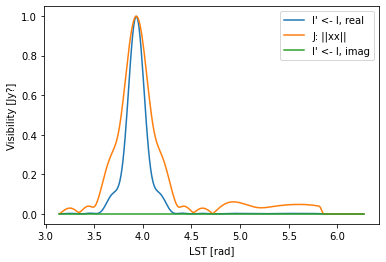

In [20]:
lst_list = [np.pi / 288 * i for i in range(288, 576)]

dec = np.radians(-30.72)

# constants for the LST plot
print("Right ascension:", ra)
print("LST interval", 1 / 288)
print("Declination:", dec)
print("Reference point:", np.radians(-30.72))

list_A = []
list_J = []

for lst in lst_list:
    J = sf.stokes.create_J(ra=ra, dec=dec, lst=lst, radians=True)
    list_J.append(J)
    A = sf.stokes.create_A(J=J)
    list_A.append(A)

list_A = np.array(list_A)
list_J = np.array(list_J)
    
print(list_A[0][0][0])

plt.plot(lst_list, np.real(list_A[:, 0, 0, 0]), label="I' <- I, real")
plt.plot(lst_list, np.abs(list_J[:, 0, 0, 0]), label="J: ||xx||")
plt.plot(lst_list, np.imag(list_A[:, 0, 0, 0]), label="I' <- I, imag")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")

plt.legend()
plt.show()

In [21]:
print("The following is the universal baseline")
print(sf.ant.baseline(88, 121))

The following is the universal baseline
[-43.92014994  25.13624112  -0.34038648]


In [22]:
len(sf.catalog.obj_catalog)

3872